Protein-DNA binding prediction (CTCF)
=============

Goal: implement DeepBing with TensorFlow
------------


***
## DeepBind:

> <img src="http://www.nature.com/nbt/journal/v33/n8/images/nbt.3300-F2.jpg" width="80%">
> Source: http://www.nature.com/nbt/journal/v33/n8/images/nbt.3300-F2.jpg


In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
K_FOLD = [4,1] ## A 5 fold
TRAIN_PICKLE = '../../../train.pickle'
TEST_PICKLE  = '../../../test.pickle'
ANS_PICKLE   = '../../../fish/ans.pickle'

with open(TRAIN_PICKLE, 'rb') as f:
    save = pickle.load(f)
    seq  = save['seq']
    labels = save['label']
    length  = seq.shape[0]
    del save
    print('\n*Loaded train.pickle: ',seq.shape, labels.shape)

with open(TEST_PICKLE, 'rb') as f:
    save = pickle.load(f)
    test_seq = save['seq']
    test_dummy_labels = save['label']
    test_length = test_seq.shape[0]
    del save
    print('\n*Loaded test.pickle: ',test_seq.shape,test_dummy_labels.shape,'\n',test_seq[0],test_dummy_labels[0])
    
with open(ANS_PICKLE, 'rb') as f:
    save = pickle.load(f)
    ans_seq = save['seq']
    ans_labels = save['label']
    ans_length = ans_seq.shape[0]
    del save
    print('\n*Loaded ans.pickle: ',ans_seq.shape,ans_labels.shape,'\n',ans_seq[0],ans_labels[0])


_ = int((length-length%(sum(K_FOLD)))/(sum(K_FOLD))) ## 15506
r_train = range(0,4*_)
r_valid = range(4*_+1,length)
r_test  = range(0,length)

train_dataset, train_labels = seq[15506:,], labels[15506:,]
valid_dataset, valid_labels = seq[0:15506,], labels[0:15506,]  
test_dataset,  test_labels  = test_seq[:] , test_dummy_labels[:]
ans_dataset,   ans_labels   = ans_seq[:], ans_labels[:]

print('\n*Training set:\t', train_dataset.shape,  train_labels.shape)
print('*Validation set:', valid_dataset.shape,  valid_labels.shape)
print('*Test set:\t',       test_dataset.shape,   test_dummy_labels.shape)
print('*Ans set:\t',      ans_seq.shape,        ans_labels.shape)
  


*Loaded train.pickle:  (77531, 121, 4) (77531, 2)

*Loaded test.pickle:  (19383, 121, 4) (19383, 2) 
 [[ 0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.25  0.25]
 [ 0.    1.    0.    0.  ]
 [ 1.    0.    0.    0.  ]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]
 [ 0.    0.    0.    1.  ]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    1.    0.  ]
 [ 0.    1.    0.    0.  ]
 [ 0.    1.    0.    0.  ]
 [ 0.    0.    0.    1.  ]
 [ 0.    1.    0.    0.  ]
 [ 1.    0.    0.    0.  ]
 [ 0.    0.    0.    1.  ]
 [ 0.    0.    0.    1.  ]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]
 [ 0.    0.    1.    0.  ]
 [ 1.    0.    0.    0.  ]
 [ 0.    0.    1.    0.  ]
 [ 1.    0.    0.    0.  ]
 [ 0.    0.    0.    1.  ]
 [ 0.    1.    0.    0.  ]
 [ 0.    0.    1.    0.  ]
 [ 0. 

In [14]:
## Export file        
DIST = './ans_labels'
print('* ans.pickle: ', ans_labels.shape)        
with open('../../../fish/ans.pickle', 'w') as f:
    for r in ans_labels:
        f.write(str(r)+'\n')        
        f.close
    print('ans.pickle saved to',DIST)    

* ans.pickle:  (19383, 2)
ans.pickle saved to ./ans_labels


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [4]:
import numpy as np

num_channels = 1
num_labels = 2

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, 121, 4, num_channels)).astype(np.float32)
#     labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels   = reformat(test_dataset, test_dummy_labels)
ans_dataset, ans_labels     = reformat(ans_dataset, ans_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_dummy_labels.shape)
print('Ans set', ans_dataset.shape, ans_labels.shape)

Training set (62025, 121, 4, 1) (62025, 2)
Validation set (15506, 121, 4, 1) (15506, 2)
Test set (19383, 121, 4, 1) (19383, 2)
Ans set (19383, 121, 4, 1) (19383, 2)


In [5]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

### DeepBind CNN Model
> <img src="http://www.nature.com/nbt/journal/v33/n8/images/nbt.3300-SF1.jpg" width="90%">
>... Shown is an example with __batch_size=5, motif_len=6, num_motifs=4, num_models=3__. Sequences are padded with ‘N’s so that the motif scan operation can find detections at both extremities. Yellow cells represent the reverse complement of the input located above; both strands are fed to the model, and the strand with the maximum score is used for the output prediction (the max strand stage). The output dimension of the pool stage, depicted as num_motifs (*), depends on whether “max” or “max and avg” pooling was used.
> 
> Image source: http://www.nature.com/nbt/journal/v33/n8/fig_tab/nbt.3300_SF1.html


## Model

In [6]:
image_size   = [121,4]  ## 101bps, plus 10bps frenking on both end
num_labels   = 2        ## bind or not (1 or 0)
batch_size   = 256      ## TODO: try with double strand input!
filter_size  = [11,4]   ## Motif detector length = 11 (about 1.5 times of expected motif length)
depth        = 16       ## Number of motif detector (num_motif) = 16
num_hidden   = 32       ## 32 ReLU units of no hidden layer at all

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size[0], image_size[1], num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_ans_dataset = tf.constant(ans_dataset)
  
    # conv filter, shape=(11,3)
    filter_W = tf.Variable(tf.truncated_normal([11, 3, num_channels, depth], stddev=0.1)) ## difference ?
    filter_b = tf.Variable(tf.zeros([depth]))

    # NN layer, shape=()
    hidden_W = tf.Variable(tf.truncated_normal([1920, 32], stddev=0.1))
    hidden_b = tf.Variable(tf.constant(1.0, shape=[32]))
    
    # output layer, shape=()
    output_W = tf.Variable(tf.truncated_normal([32, 2], stddev=0.1))
    output_b = tf.Variable(tf.constant(1.0, shape=[2]))
 

    ## Model.
    def model(data):
        print('           [batch, height, width, channel]') 
        print('data:     ', data.get_shape().as_list())
        
        # Convolution: (121,4,1) ---- 3x6 filter ---> (121,4,4)
        conv = tf.nn.conv2d(data, filter_W, [1, 1, 1, 1], padding='SAME')
        print('conv:     ', conv.get_shape().as_list())
        
        relu = tf.nn.relu(conv + filter_b)
        print('relu:     ', relu.get_shape().as_list())

        pool = tf.nn.max_pool(relu, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
        print('pooling:  ', pool.get_shape().as_list())
        
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
        print('reshape:  ', reshape.get_shape().as_list())
        
        hidden = tf.nn.relu(tf.matmul(reshape, hidden_W) + hidden_b)
        print('hidden:   ', hidden.get_shape().as_list())
        
        output = tf.nn.relu(tf.matmul(hidden, output_W) + output_b)
        print('output:   ', output.get_shape().as_list(),'\n\n')
        return output
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction  = tf.nn.softmax(model(tf_test_dataset))
    ans_prediction   = tf.nn.softmax(model(tf_ans_dataset))

           [batch, height, width, channel]
data:      [256, 121, 4, 1]
conv:      [256, 121, 4, 16]
relu:      [256, 121, 4, 16]
pooling:   [256, 60, 2, 16]
reshape:   [256, 1920]
hidden:    [256, 32]
output:    [256, 2] 


           [batch, height, width, channel]
data:      [15506, 121, 4, 1]
conv:      [15506, 121, 4, 16]
relu:      [15506, 121, 4, 16]
pooling:   [15506, 60, 2, 16]
reshape:   [15506, 1920]
hidden:    [15506, 32]
output:    [15506, 2] 


           [batch, height, width, channel]
data:      [19383, 121, 4, 1]
conv:      [19383, 121, 4, 16]
relu:      [19383, 121, 4, 16]
pooling:   [19383, 60, 2, 16]
reshape:   [19383, 1920]
hidden:    [19383, 32]
output:    [19383, 2] 


           [batch, height, width, channel]
data:      [19383, 121, 4, 1]
conv:      [19383, 121, 4, 16]
relu:      [19383, 121, 4, 16]
pooling:   [19383, 60, 2, 16]
reshape:   [19383, 1920]
hidden:    [19383, 32]
output:    [19383, 2] 




## Session

In [15]:
%matplotlib inline

def run_session(num_steps = 1000, DIST = './Prediction_19383.data'):
    
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        print('\t',     'Minibatch\t', 'Minibatch\t',  'Validation')
        print('Step\t', 'Loss\t\t',      'Accuracy\t',  'Accuracy')
        x, y = [], []
        for step in range(num_steps+1):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % int(num_steps/20) == 0):
                x.append(accuracy(predictions, batch_labels))
                y.append(accuracy(valid_prediction.eval(), valid_labels))
                print('%d\t %f\t %.1f%%\t\t %.1f%%\t' % (
                    step,
                    l,
                    accuracy(predictions, batch_labels),
                    accuracy(valid_prediction.eval(), valid_labels)
                ))
        plt.plot(range(0, len(x)),x , label='Minibatch')
        plt.plot(range(0, len(y)),y , label='Validation')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.ylabel('Accuracy')
        plt.xlabel('Iteration')
        plt.show()
        print('*** TEST ACCURACY(dummy): %.1f%% ***' % accuracy(test_prediction.eval(), test_dummy_labels))
        print('*** ANS ACCURACY: %.1f%% ***' % accuracy(ans_prediction.eval(), ans_labels))
        results = ans_prediction.eval()
    
        ## Export file        
        print('* ans_prediction.eval(): ', results)
        results = np.argmax(results, axis=1)
        print('* results: ', results)        
        with open(DIST, 'w') as f:
            for r in results:
                f.write(str(r)+'\n')        
                f.close
            print('Prediction result saved to',DIST)    
            
    return results
    
            

	 Minibatch	 Minibatch	 Validation
Step	 Loss		 Accuracy	 Accuracy
0	 0.726380	 48.4%		 49.0%	
50	 0.692544	 54.3%		 51.4%	
100	 0.687551	 53.5%		 50.5%	
150	 0.699347	 49.6%		 54.0%	
200	 0.691198	 53.1%		 55.3%	
250	 0.694991	 52.0%		 55.5%	
300	 0.695008	 52.7%		 57.9%	
350	 0.673173	 59.8%		 58.0%	
400	 0.689820	 54.7%		 55.0%	
450	 0.676622	 56.6%		 61.8%	
500	 0.631358	 64.8%		 62.2%	
550	 0.670135	 58.2%		 59.4%	
600	 0.628820	 65.2%		 61.9%	
650	 0.616791	 64.1%		 62.8%	
700	 0.603258	 69.9%		 57.6%	
750	 0.608723	 68.0%		 66.1%	
800	 0.642044	 62.5%		 59.5%	
850	 0.611376	 65.6%		 68.1%	
900	 0.592239	 68.8%		 66.2%	
950	 0.589193	 71.1%		 69.7%	
1000	 0.631427	 61.7%		 68.1%	


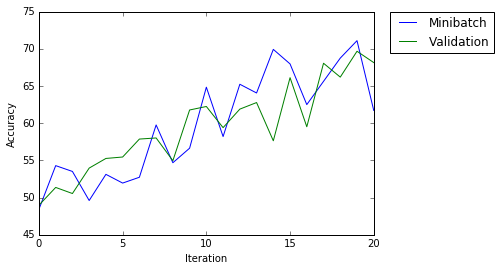

*** TEST ACCURACY: 69.7% ***
*** ANS ACCURACY: 68.1% ***
* ans_prediction.eval():  [[ 0.75219434  0.24780573]
 [ 0.62626356  0.37373644]
 [ 0.82774812  0.17225188]
 ..., 
 [ 0.71071959  0.28928047]
 [ 0.52742964  0.47257036]
 [ 0.53305811  0.46694189]]
* results:  [0 0 0 ..., 0 0 0]
Prediction result saved to ./Prediction_19383_1000steps.data


In [10]:
result_1000 = run_session(1000, DIST = './Prediction_19383_1000steps.data')

	 Minibatch	 Minibatch	 Validation
Step	 Loss		 Accuracy	 Accuracy
0	 0.739284	 48.0%		 49.2%	
400	 0.693391	 55.9%		 50.8%	
800	 0.693398	 46.1%		 50.7%	
1200	 0.690267	 50.0%		 50.7%	
1600	 0.687480	 46.1%		 50.7%	
2000	 0.678466	 44.5%		 50.7%	
2400	 0.670504	 48.0%		 51.0%	
2800	 0.549879	 73.0%		 69.9%	
3200	 0.610140	 69.1%		 67.5%	
3600	 0.604669	 65.6%		 72.4%	
4000	 0.541892	 73.0%		 74.3%	
4400	 0.444828	 80.9%		 76.3%	
4800	 0.413186	 81.6%		 77.7%	
5200	 0.420222	 80.1%		 77.8%	
5600	 0.398285	 81.2%		 80.3%	
6000	 0.409523	 84.8%		 81.1%	
6400	 0.437637	 80.5%		 81.2%	
6800	 0.391691	 81.6%		 82.3%	
7200	 0.374179	 83.2%		 82.7%	
7600	 0.343063	 84.0%		 82.5%	
8000	 0.376838	 85.5%		 81.9%	


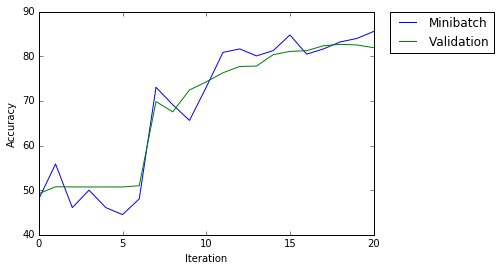

*** TEST ACCURACY: 43.4% ***
*** ANS ACCURACY: 81.9% ***
* ans_prediction.eval():  [[ 0.19000204  0.80999798]
 [ 0.54060632  0.45939365]
 [ 0.7378602   0.2621398 ]
 ..., 
 [ 0.97381759  0.02618245]
 [ 0.39285848  0.60714155]
 [ 0.47253528  0.52746475]]
* results:  [1 0 0 ..., 0 1 1]
Prediction result saved to ./Prediction_19383_8000steps.data


In [11]:
result_8000 = run_session(8000, DIST = './Prediction_19383_8000steps.data')

	 Minibatch	 Minibatch	 Validation
Step	 Loss		 Accuracy	 Accuracy
0	 0.812564	 52.0%		 50.7%	
600	 0.623794	 68.8%		 63.5%	
1200	 0.586360	 70.3%		 70.6%	
1800	 0.491320	 77.7%		 73.4%	
2400	 0.449061	 79.7%		 74.0%	
3000	 0.480724	 78.9%		 74.6%	
3600	 0.514147	 75.0%		 77.3%	
4200	 0.457493	 78.1%		 77.8%	
4800	 0.450495	 78.9%		 76.2%	
5400	 0.389566	 83.6%		 80.8%	
6000	 0.390954	 83.2%		 81.9%	
6600	 0.344714	 84.8%		 82.1%	
7200	 0.348730	 87.1%		 82.6%	
7800	 0.327689	 85.9%		 83.4%	
8400	 0.356189	 83.6%		 83.2%	
9000	 0.369209	 84.4%		 80.8%	
9600	 0.368652	 81.6%		 83.2%	
10200	 0.322857	 87.5%		 83.7%	
10800	 0.301181	 87.1%		 82.0%	
11400	 0.334048	 86.3%		 83.6%	
12000	 0.274088	 89.8%		 84.6%	


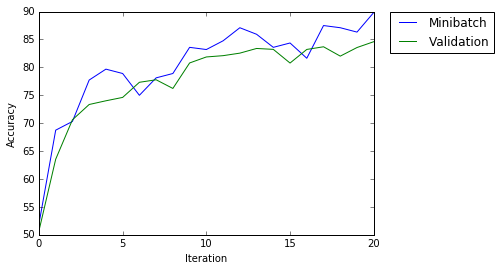

*** TEST ACCURACY: 50.2% ***
*** ANS ACCURACY: 84.2% ***
* ans_prediction.eval():  [[ 0.69502193  0.30497807]
 [ 0.79221255  0.20778747]
 [ 0.93743449  0.06256557]
 ..., 
 [ 0.83827353  0.16172646]
 [ 0.38660493  0.61339504]
 [ 0.77886081  0.22113921]]
* results:  [0 0 0 ..., 0 1 0]
Prediction result saved to ./Prediction_19383_12000steps.data


In [12]:
result_12000 = run_session(12000, DIST = './Prediction_19383_12000steps.data')